Datased sourced from Kaggle: https://www.kaggle.com/datasets/martinsn/high-frequency-crypto-limit-order-book-data?resource=download&select=BTC_1sec.csv

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from numba import jit

In [3]:
data = pd.read_csv("C:/Users/Saverio/Documents/GitHub/python_defi_project/data/BTC_1sec.csv", index_col= 1, parse_dates= True)
data = data.drop(["Unnamed: 0"], axis = 1)
data.index.name = "Time"

In [4]:
pd.options.display.float_format = '{:.4f}'.format

data[["midpoint", "spread", "buys", "sells"]].describe().iloc[1:]

,midpoint,spread,buys,sells
mean,59975.0702,1.3140,6060.0579,5278.9002
std,2490.0488,4.7133,32348.1856,35807.5706
min,51978.1800,0.0100,0.0000,0.0000
25%,58000.0050,0.0100,8.9713,0.0000
50%,60146.5850,0.0100,264.0874,0.0000
75%,62187.7550,0.0100,1747.1508,603.0148
max,64896.7450,1245.1000,4060005.1483,5215817.0009


From the description on the Kaggle page, we know that the data contains information for the 15 best bid / ask price levels in the order book. 

Moreover, this is a description of what each column represents:

* **midpoint**: The midpoint between the best bid and the best ask.
* **spread**: The difference between the best bid and the best ask.
* **bids\_distance\_x**: The distance of bid level x from the midprice in %.
* **asks\_distance\_x**: The distance of ask level x from the midprice in %.
* **bids\_market\_notional\_x**: Volume of market orders at bid level x.
* **bids\_limit\_notional\_x**: Volume of limit orders at bid level x.
* **bids\_cancel\_notional\_x**: Volume of canceled orders at bid level x.
* **asks\_market\_notional\_x**: Volume of market orders at ask level x.
* **asks\_limit\_notional\_x**: Volume of limit orders at ask level x.
* **asks\_cancel\_notional\_x**: Volume of canceled orders at ask level x.

In [6]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset has 1030728 rows and 154 columns.


In [7]:
bid_notional = [x for x in data.columns if "bids_notional" in x]
bid_cancel_notional = [x for x in data.columns if "bids_cancel_notional" in x]
bid_limit_notional = [x for x in data.columns if "bids_limit_notional" in x]
bid_market_notional = [x for x in data.columns if "bids_market_notional" in x]

ask_notional = [x for x in data.columns if "asks_notional" in x]
ask_cancel_notional = [x for x in data.columns if "asks_cancel_notional" in x]
ask_limit_notional = [x for x in data.columns if "asks_limit_notional" in x]
ask_market_notional = [x for x in data.columns if "asksx_market_notional" in x]

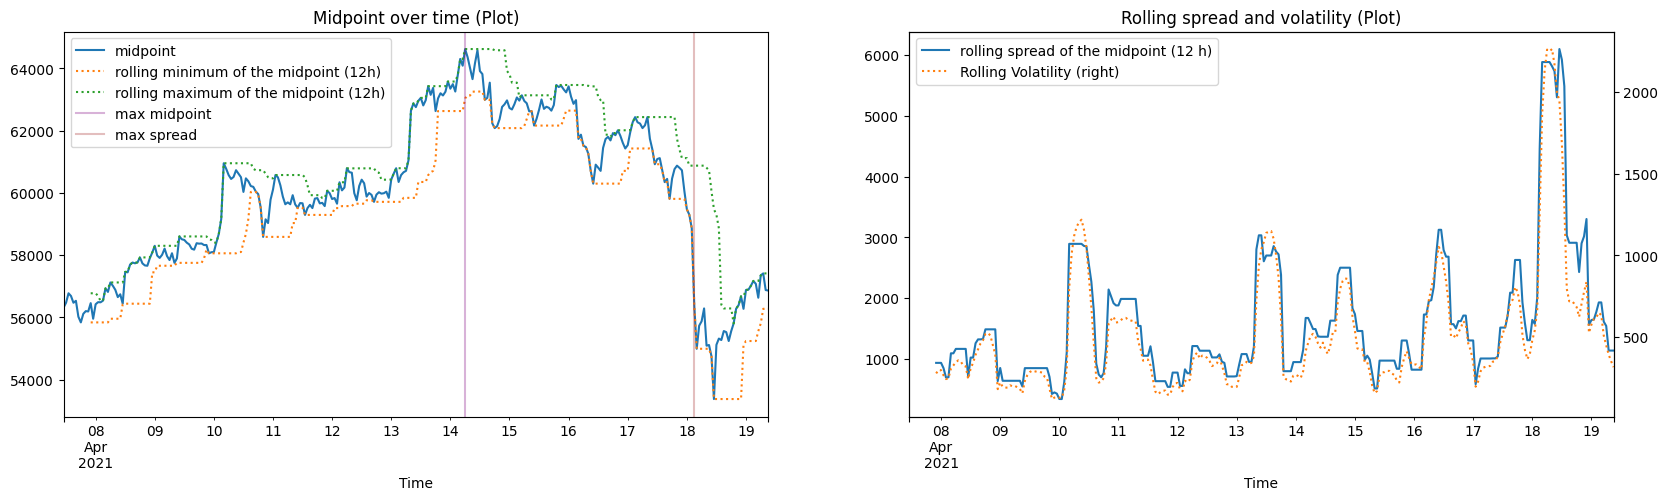

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

data["midpoint"].resample("1H").last().plot(label = "midpoint", legend = True, title = "Midpoint over time (Plot)", ax = axes[0]);

data["midpoint"].resample("1H").last().rolling(12).min().plot(label = "rolling minimum of the midpoint (12h)", legend = True, linestyle = ":", ax = axes[0]);
data["midpoint"].resample("1H").last().rolling(12).max().plot(label = "rolling maximum of the midpoint (12h)", legend = True, linestyle = ":", ax = axes[0]);

highest_midpoint = data["midpoint"].idxmax()
lowest_midpoint = data["midpoint"].idxmin()

highest_spread = data["spread"].idxmax()

# axes[0].axvline(lowest_midpoint, color = "red", alpha = 0.3, label = "min midpoint")
axes[0].axvline(highest_midpoint, color = "purple", alpha = 0.3, label = "max midpoint")
axes[0].axvline(highest_spread, color = "brown", alpha = 0.3, label = "max spread")
axes[0].legend()

(data["midpoint"].resample("1H").last().rolling(12).max()-data["midpoint"].resample("1H").last().rolling(12).min()).plot(label = "rolling spread of the midpoint (12 h)", legend = True, linestyle = "-", ax = axes[1],
                                                                                                                         title = "Rolling spread and volatility (Plot)");
data["midpoint"].resample("1H").last().rolling(12).std().plot(label = "Rolling Volatility", legend = True, linestyle = ":", ax = axes[1], secondary_y= True);


In [17]:
prediction_horizon = 10
price_change_threshold = 0.0001

data["future_midpoint"] = data["midpoint"].shift()
data["price_change"] = np.log(data["future_midpoint"])-np.log(data["midpoint"])

data["target"] = 0
data.loc[data["price_change"]> price_change_threshold, "target"] = 1
data.loc[data["price_change"] < -price_change_threshold, "target"] = -1

data.dropna(subset = ["future_midpoint", "price_change", "target"], inplace= True)

print("\n Target Variable Distribution:")
print(data["target"].value_counts(normalize= True))


 Target Variable Distribution:
 0   0.8827
-1   0.0589
 1   0.0584
Name: target, dtype: float64
